# Election simulator, polls only

Methodology:

For a single battleground state, say Florida

Take a kernel density estimate of the Biden and Trump polling sample data

This should be a single KDE fitted to net Biden margin (>0 = he wins, <0= he loses)

Optimise the bandwidth according to some objective

Run 10k pseudoexperiments by sampling from this KDE, compute the distribution of outcomes

In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ds_toolbox.modelling.time_series_utils as ts
import ds_toolbox.modelling.misc_utils as ds
from ds_toolbox.visualisation import corrplot, bokeh_chart, bokeh_candlestick, plot_colors

from bokeh.plotting import show, output_notebook
output_notebook()

# pd.set_option("display.max_columns", None)

Loading BokehJS ...

In [9]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [12]:
raw = pd.read_csv("data/presidential_polls_2020_538.csv")

raw.created_at = pd.to_datetime(raw.created_at)
raw = raw[raw.answer.isin(["Biden", "Trump"])]

# keep only state-level polls
raw = raw[raw.state.notna()]

# keep only answers from likely voters (population and population_full are always equal)
raw = raw[raw.population == "lv"]

In [13]:
states = raw.state.unique()

In [16]:
wide = raw.pivot_table(index="created_at", columns=["state", "answer"], values="pct")

In [17]:
battlegrounds = ['Arizona',
 'Colorado',
 'Florida',
 'Georgia',
 'Iowa',
 'Maine',
 'Michigan',
 'Minnesota',
 'Nevada',
 'New Hampshire',
 'New Mexico',
 'North Carolina',
 'Ohio',
 'Pennsylvania',
 'Texas',
 'Virginia',
 'Wisconsin']

party_colors = ["red", "dodgerblue"]

## test KDE on single state (skip)

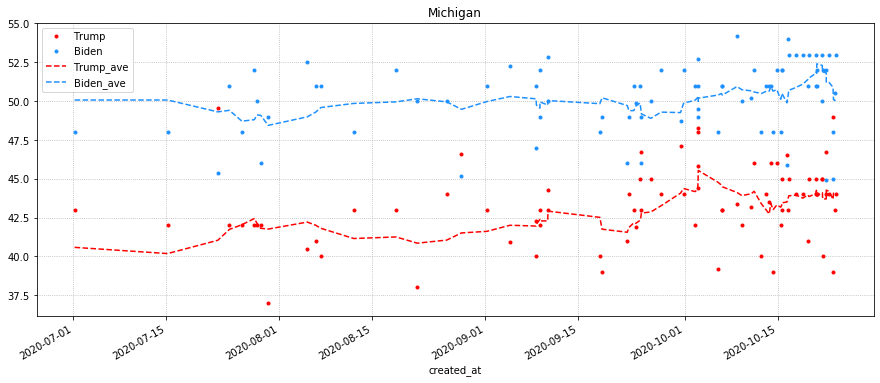

In [130]:
for state in ["Michigan"]:
    plot_df = wide[state].dropna()[["Trump", "Biden"]]
    plot_df_roll = plot_df.rolling(window=10, min_periods=3).mean()
    plot_df_roll.columns = ["Trump_ave", "Biden_ave"]
    plot_df = plot_df.merge(plot_df_roll, left_index=True, right_index=True, how="left")
    ts.plot(plot_df, style=[".", ".", "--", "--"], start_date="2020-07", color=2*party_colors)
    plt.title(state);


In [131]:
df = plot_df[plot_df.index >= "2020-07"]

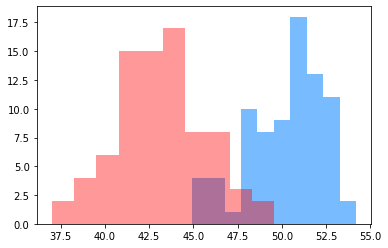

In [132]:
plt.hist(df.Biden, bins=10, color="dodgerblue", alpha=0.6);
plt.hist(df.Trump, bins=10, color="red", alpha=0.4);


In [277]:
# plt.hist(df.Biden - df.Trump, bins=40, color="mediumpurple", alpha=0.8);

0.9292


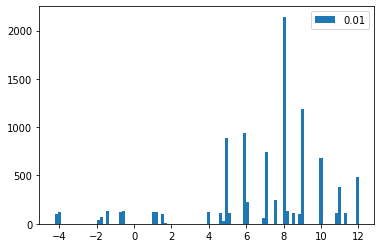

0.9251


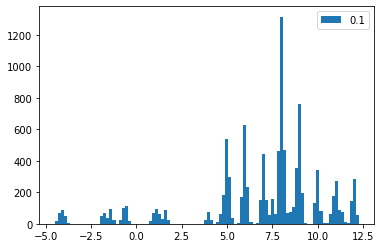

0.9259


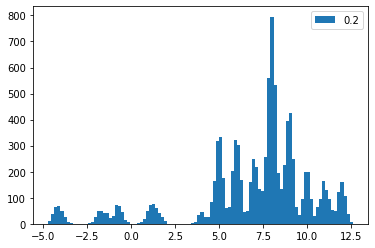

0.9266


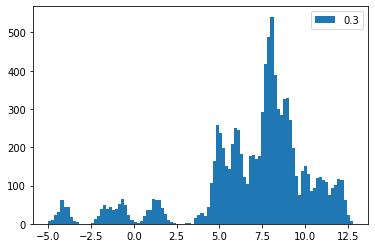

0.9254


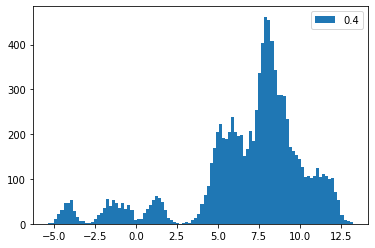

0.9215


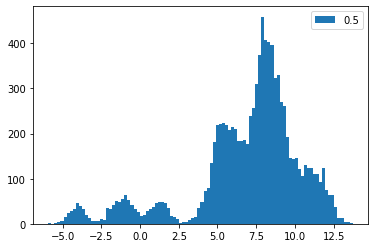

0.9266


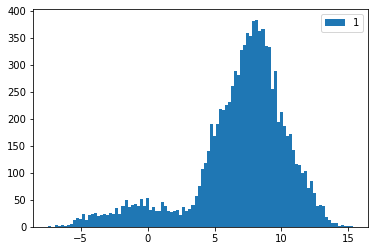

0.9286


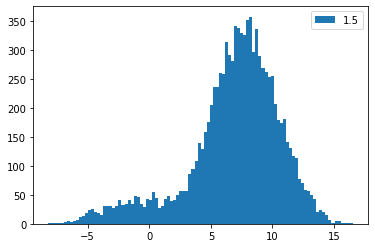

0.9214


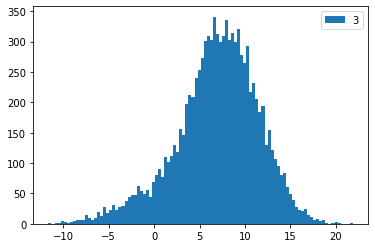

0.8778


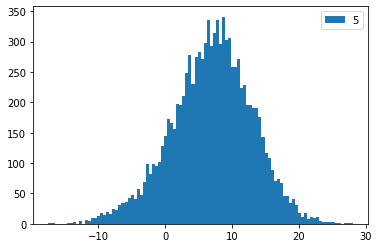

In [182]:
for bandwidth in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 3, 5]:
    net_biden = (df.Biden - df.Trump).to_frame()
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(net_biden)
    samples = kde.sample(10000)
    plt.hist(samples, bins=100, label=str(bandwidth));
    frac_biden = (np.squeeze(samples) > 0).sum() / 10000
    print(frac_biden)
    plt.legend()
    plt.show()

In [115]:
# X = np.linspace(40, 60, 51).reshape(-1, 1)
# log_dens = kde.score_samples(X)
# plt.plot(X, np.exp(log_dens));

## optimise bandwidth

In [129]:
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(kernel="gaussian"), params)
grid.fit(net_biden)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# seems way too low

best bandwidth: 0.26366508987303583


## All batteground states  

Use bandwidth of 5

In [137]:
safe_rep = ['Alabama',
 'Alaska',
 'Arkansas',
 'Idaho',
 'Indiana',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'North Dakota',
 'Oklahoma',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Utah',
 'West Virginia',
 'Wyoming']

safe_dem = ['California',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Hawaii',
 'Illinois',
 'Maryland',
 'Massachusetts',
 'New Jersey',
 'New York',
 'Oregon',
 'Rhode Island',
 'Vermont',
 'Washington']

In [135]:
# downloaded from https://state.1keydata.com/state-electoral-votes.php
votes_per_state = pd.read_csv("data/electoral_votes_per_state.csv", 
                              header=None, index_col=0, names=["votes"]).squeeze()


In [236]:
n_mc = 10000

df_all = pd.DataFrame(index=range(n_mc), columns=states)

df_all[safe_dem] = "D"
df_all[safe_rep] = "R"

In [250]:
for state in battlegrounds:
    results = simulate_state(state, n_mc=n_mc, bandwidth=5)
    df_all[state] = results

In [251]:
dem_distr = np.empty(n_mc)
rep_distr = np.empty(n_mc)

for i, row in df_all.iterrows():
    dem_total = (votes_per_state[row[row == "D"].index]).sum()
    rep_total = (votes_per_state[row[row == "R"].index]).sum()
    
    dem_distr[i] = dem_total
    rep_distr[i] = rep_total

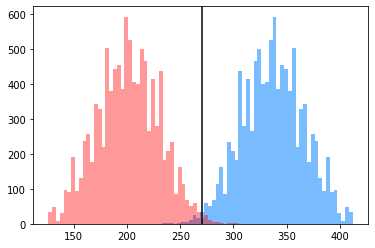

In [276]:
plt.hist(dem_distr, bins=50, color="dodgerblue", alpha=0.6);
plt.hist(rep_distr, bins=50, color="red", alpha=0.4);
plt.axvline(x=270, color="black");

In [260]:
# biden win probabilities in battleground states
for state in battlegrounds:

    res = df_all[state].value_counts(normalize=True)["D"]
    print(state, res)

Arizona 0.7078
Colorado 0.9885
Florida 0.6802
Georgia 0.5018
Iowa 0.4697
Maine 0.9855
Michigan 0.8723
Minnesota 0.9167
Nevada 0.7578
New Hampshire 0.9726
New Mexico 0.8951
North Carolina 0.6403
Ohio 0.3651
Pennsylvania 0.832
Texas 0.3522
Virginia 0.9841
Wisconsin 0.8862


In [263]:
(dem_distr > 270).sum() / n_mc

0.9905

Assuming states are independent gives a massive Biden win probability.

In [235]:
def simulate_state(state, n_mc=10000, bandwidth=5):
    
    df = wide[state].dropna()[["Trump", "Biden"]]
    df = df[df.index >= "2020-07"]
        
    net_biden = (df.Biden - df.Trump).to_frame()
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(net_biden)
        
    samples = kde.sample(n_mc)
    results = np.squeeze(samples) > 0    
    results = np.array(list(map(mapping.get, results)))
    
    return results
    